In [1]:
%config InlineBackend.figure_formats = ['svg']
import os
import json
import maup
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from gerrychain import Graph
from pcompress import Replay
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import sparse
from hashlib import sha512

In [2]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

In [36]:
output_dir = '../../UT/outputs'
coi_shapefile_path = '../../UT/data/UT-COI-raw'
block_shapefile_path = '../../UT/data/tl_2020_49_tabblock20'
proj = 'EPSG:32612'
state_fips_code = '49'
output_prefix = 'ut_congress_coi_preservation'
plans_path = '../../UT/data/final_plans'
block_pops_path = '../../UT/data/tl_2020_49_block_total_pop.json'
vtd_graph_path = '/Users/pjrule/Dropbox/MGGG/plan-evaluation-reporting/dual_graphs/ut_vtds20.json'
baf_path = '../../UT/data/BlockAssign_ST49_UT'
chain_path = '../../UT/data/utah_congress_0.01_bal_100000_steps_county_aware.chain'
selected_plans = [
  {'id': 'congress/Purple', 'label': 'Purple', 'color': 'tab:purple'}
]
figure_title = 'Utah COI preservation (Congress)'

In [37]:
os.makedirs(os.path.join(output_dir, output_prefix), exist_ok=True)

In [4]:
vtd_block_path = os.path.join(baf_path, baf_path.split('/')[-1] + '_VTD.txt')
vtd_block_df = pd.read_csv(vtd_block_path, sep='|', dtype=str).set_index('BLOCKID')
vtd_block_df['vtd_id'] = state_fips_code + vtd_block_df['COUNTYFP'].str.zfill(3) + vtd_block_df['DISTRICT'].str.zfill(6)
blocks_by_vtd = defaultdict(set)
for block, vtd in vtd_block_df['vtd_id'].items():
  blocks_by_vtd[vtd].add(block)

In [5]:
graph = Graph.from_json(vtd_graph_path)

In [6]:
block_pop_df = pd.read_json(block_pops_path)
block_pop_df['GEOID20'] = (
  block_pop_df['state'].astype(str)  +
  block_pop_df['county'].astype(str).str.zfill(3) + 
  block_pop_df['tract'].astype(str).str.zfill(6) + 
  block_pop_df['block'].astype(str).str.zfill(4)
)
block_pop_df = block_pop_df.set_index('GEOID20')

In [7]:
block_pops = dict(block_pop_df['P1_001N'])

In [8]:
coi_gdf = gpd.read_file(coi_shapefile_path).to_crs(proj).set_index('PlanID')
coi_gdf = coi_gdf[coi_gdf['MeetsMinim'] == 'Yes']  # remove low-quality submissions

In [9]:
coi_hash = sha512(' '.join(sorted(coi_gdf.index.tolist())).encode('utf-8')).hexdigest()[:16]

In [10]:
try:
  with open(os.path.join(output_dir, f'blocks_by_coi_cache_{coi_hash}.json')) as f:
    blocks_by_coi = {
      coi: set(blocks) for coi, blocks in json.load(f).items()
    }
except FileNotFoundError:
  print('Rebuilding cache...')
  block_gdf = gpd.read_file(block_shapefile_path).to_crs(proj).set_index('GEOID20')
  assert not set(block_gdf.index) - set(block_pops.keys())
  assert not set(block_pops.keys()) - set(block_gdf.index)
  block_areas = dict(block_gdf.geometry.apply(lambda geom: geom.area))
  with maup.progress():
    coi_blocks = maup.intersections(coi_gdf, block_gdf)
  blocks_by_coi = defaultdict(set)
  for (coi, block), geom in coi_blocks.geometry.items():
    if geom.area > 0.01 * block_areas[block]:
      blocks_by_coi[coi].add(block)
  with open(os.path.join(output_dir, f'blocks_by_coi_cache_{coi_hash}.json'), 'w') as f:
    json.dump({coi: list(blocks) for coi, blocks in blocks_by_coi.items()}, f)

In [11]:
node_ordering = {k: idx for idx, k in enumerate(blocks_by_vtd.keys())}

In [12]:
vtd_coi_inter_pops = np.zeros((len(blocks_by_coi), len(blocks_by_vtd)))
for vtd_idx, (vtd, vtd_blocks) in tqdm(enumerate(blocks_by_vtd.items())):
  for coi_idx, (coi, coi_blocks) in enumerate(blocks_by_coi.items()):
    vtd_coi_inter_pops[coi_idx, vtd_idx] = sum(
      block_pops[b]
      for b in vtd_blocks & coi_blocks
    )
vtd_coi_inter_pops = sparse.csr_matrix(vtd_coi_inter_pops)

2745it [00:09, 279.93it/s]


In [13]:
coi_pops_by_id = {coi_id: sum(block_pops[b] for b in blocks) for coi_id, blocks in blocks_by_coi.items()}
coi_pops = np.array(list(coi_pops_by_id.values()))

In [14]:
totpop = sum(data['TOTPOP'] for _, data in graph.nodes(data=True))

In [15]:
selected_plan_ids = {p['id'] for p in selected_plans}

In [29]:
plans = {}
for outer_path, _, filenames in os.walk(plans_path):
  for filename in filenames:
    full_path = os.path.join(outer_path, filename)
    short_name = '/'.join(full_path[:-4].split('/')[-2:])
    if filename.endswith('.csv') and short_name in selected_plan_ids:
      assignment = dict(pd.read_csv(full_path, dtype={'GEOID20': 'str', 'assignment': int}).set_index('GEOID20')['assignment'])
      plan_id = full_path[:-4]
      if plan_id in plans:
        assert assignment == plans[plan_id], 'Inconsistent assignment'
      plans[plan_id] = assignment

In [30]:
plans_inverted = {}
for plan_id, assignment in plans.items():
  dists = defaultdict(set)
  for block, dist in assignment.items():
    dists[dist].add(block)
  plans_inverted[plan_id] = dists

In [18]:
def thresholded_scores_blocks(dists):
  scores_by_threshold = {thres / 40: 0 for thres in range(20, 41)}
  for coi_id, blocks_in_coi in blocks_by_coi.items():
    for dist_id, blocks_in_dist in dists.items():
      inter = blocks_in_coi & blocks_in_dist
      inter_pop = sum(block_pops[b] for b in inter)
      pop_share = inter_pop / coi_pops_by_id[coi_id]
      for threshold in scores_by_threshold:
        scores_by_threshold[threshold] += pop_share >= threshold
  return scores_by_threshold

In [19]:
def assignment_to_matrix(assignment):
  """Converts a 1-indexed assignment vector to a per-district binary encoding."""
  assert min(assignment.values()) == 1
  dist_mat = np.zeros((len(blocks_by_vtd), max(assignment.values())))
  for node, dist in assignment.items():
    dist_mat[node_ordering[graph.nodes[node]['GEOID20']], int(dist) - 1] = 1
  return dist_mat

In [20]:
def thresholded_scores_vtd(dist_mat, threshold_intervals=20):
  # First criterion: X% of a COI is contained in a single district.
  coi_dist_pops = vtd_coi_inter_pops @ dist_mat
  max_district_pop_in_coi = np.max(coi_dist_pops, axis=1)  
  score_by_threshold = {}
  ideal_dist_pop = totpop / dist_mat.shape[1]
  for threshold in range(threshold_intervals, 2 * threshold_intervals + 1):
    normed_threshold = threshold / (2 * threshold_intervals)
    score_by_threshold[normed_threshold] = (max_district_pop_in_coi >= normed_threshold * coi_pops).sum()
  return score_by_threshold

In [31]:
plan_scores = {}
for plan_id, dists in plans_inverted.items():
  short_id = '/'.join(plan_id.split('/')[-2:])
  plan_scores[short_id] = thresholded_scores_blocks(dists)

In [23]:
chain_scores = []
if chain_path is not None:
  for idx, partition in tqdm(enumerate(Replay(graph, chain_path))):
    chain_scores.append(thresholded_scores_vtd(assignment_to_matrix(partition.assignment)))
    #if idx >= 500: break

500it [00:23, 21.15it/s]


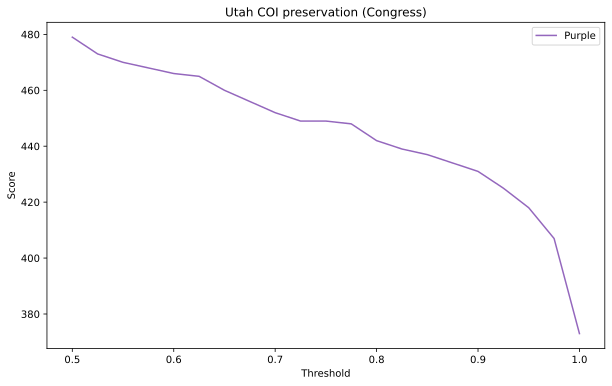

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
for plan in selected_plans:
  ax.plot(plan_scores[plan['id']].keys(), plan_scores[plan['id']].values(), label=plan['label'], color=plan['color'])
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title(figure_title)
plt.legend()
plt.savefig(os.path.join(output_dir, output_prefix, f'{output_prefix}_traces.png'), dpi=300, transparent=True)
plt.close()

In [39]:
for threshold in next(iter(plan_scores.values())):
  fig, ax = plt.subplots(figsize=(8, 8))
  if chain_scores:
    ax.hist([c[threshold] for c in chain_scores], alpha=0.3, density=True, label='County-aware ensemble', color='k')
  for plan in selected_plans:
    ax.axvline(plan_scores[plan['id']][threshold], color=plan['color'], label=f"{plan['label']} ({plan_scores[plan['id']][threshold]})", linewidth=3)
  ax.set_xlabel(f'Score ({int(threshold * 1000) / 10}% population inclusion)')
  ax.set_ylabel('Ensemble frequency')
  ax.set_title(figure_title)
  plt.legend()
  plt.savefig(os.path.join(output_dir, output_prefix, f'{output_prefix}_hist_{threshold}.png'), dpi=300, transparent=True)
  plt.close()